In [ ]:
# data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
# data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)

In [2]:
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 17.0 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

In [5]:
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"

In [6]:
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)

2748572632/2748572632 [==============================] - 116s 0us/step


In [7]:
wave_Path = data_path+'/wavs/'
metadata_Path = data_path+"/metadata.csv"

In [8]:
import csv

meta_df = pd.read_csv(metadata_Path, sep="|", header=None, quoting=3)

In [9]:
meta_df.tail()

,0,1,2
13095,LJ050-0274,made certain recommendations which it believes...,made certain recommendations which it believes...
13096,LJ050-0275,materially improve upon the procedures in effe...,materially improve upon the procedures in effe...
13097,LJ050-0276,"As has been pointed out, the Commission has no...","As has been pointed out, the Commission has no..."
13098,LJ050-0277,with the active cooperation of the responsible...,with the active cooperation of the responsible...
13099,LJ050-0278,the recommendations we have here suggested wou...,the recommendations we have here suggested wou...


In [10]:
# Assuming meta_df is your DataFrame
columns_to_remove = [1]
meta_df = meta_df.drop(columns=columns_to_remove)

In [11]:
meta_df.head()

,0,2
0,LJ001-0001,"Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...


In [12]:
# Renaming the columns of the DataFrame to "file_name" and "normalized_transcription"
meta_df.columns=["file_name","normalized_transcription"]

# Randomly shuffling the total rows(frac = 1) of the DataFrame and resetting the index to new
meta_df = meta_df.sample(frac=1).reset_index(drop=True)

meta_df.head(3)

,file_name,normalized_transcription
0,LJ026-0072,"The sap travels throughout the whole plant, th..."
1,LJ040-0119,"When Pic returned home, Mrs. Oswald tried to p..."
2,LJ042-0007,"At the age of nineteen, Oswald thus committed ..."


In [13]:
from sklearn.model_selection import train_test_split
# Split the data into train and test sets
train_df, test_df = train_test_split(meta_df, test_size=0.1, random_state=42)

In [14]:
# Display the first 3 rows of the training set
print("Training set:")
print(train_df.head(3))

# Display the first 3 rows of the test set
print("\nTest set:")
print(test_df.head(3))

Training set:
       file_name                           normalized_transcription
2673  LJ028-0268  Mounting upon the battlements that crowned the...
8233  LJ018-0215  William Roupell was the eldest but illegitimat...
9681  LJ031-0061  Dr. Fouad Bashour, chief of cardiology, Dr. M....

Test set:
       file_name                           normalized_transcription
4347  LJ011-0077  The act for which he was taken into custody wa...
7732  LJ047-0196  The Commission has considered carefully the qu...
3545  LJ007-0215  are the association of prisoners, and the unus...


In [15]:
print(len(train_df))
print(len(test_df))

11790
1310


In [16]:
# Line 1: Create a list of characters, including lowercase letters, commas, question marks, exclamation marks, and space.
characters = [x for x in 'abcdefghijklmnopqrstuvwxyz,?! ']

# Line 3: Create a StringLookup layer mapping characters to numeric indices, with the ability to handle out-of-vocabulary (oov) tokens.
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

#Line 5: Create another StringLookup layer to map numeric indices back to characters, using the vocabulary from the char_to_num layer.
# This layer also has the ability to handle out-of-vocabulary (oov) tokens and is set to invert the mapping (numeric to character).
num_to_char = keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)


print(f"the vocab is: {char_to_num.get_vocabulary()}"
       f"(size: {char_to_num.vocabulary_size()})"  )

the vocab is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ',', '?', '!', ' '](size: 31)


In [17]:
frame_length = 256
frame_step = 160
fft_length = 384

In [18]:
def encode_single_sample(wav_file, label):
    file = tf.io.read_file(wave_Path+wav_file+'.wav')

    audio, _ = tf.audio.decode_wav(file)

    audio = tf.squeeze(audio, axis = -1)
    audio = tf.cast(audio, tf.float32)

    spectrogram = tf.signal.stft(audio, frame_length = frame_length, frame_step=frame_step, fft_length=fft_length)

    spectrogram = tf.abs(spectrogram)

    spectrogram = tf.math.pow(spectrogram,0.5)

    means  = tf.math.reduce_mean(spectrogram,1, keepdims=True)
    stddev = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram -means)/(stddev + 1e-10)

    label = tf.strings.lower(label)

    label = tf.strings.unicode_split(label, input_encoding="UTF-8")

    label = char_to_num(label)

    return spectrogram, label

In [19]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(train_df['file_name']), list(train_df['normalized_transcription'])))

train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size = tf.data.AUTOTUNE)
    )

test_dataset = tf.data.Dataset.from_tensor_slices(
    (list(test_df['file_name']), list(test_df['normalized_transcription']))
    )

test_dataset = (
    test_dataset.map(encode_single_sample,num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size = tf.data.AUTOTUNE))

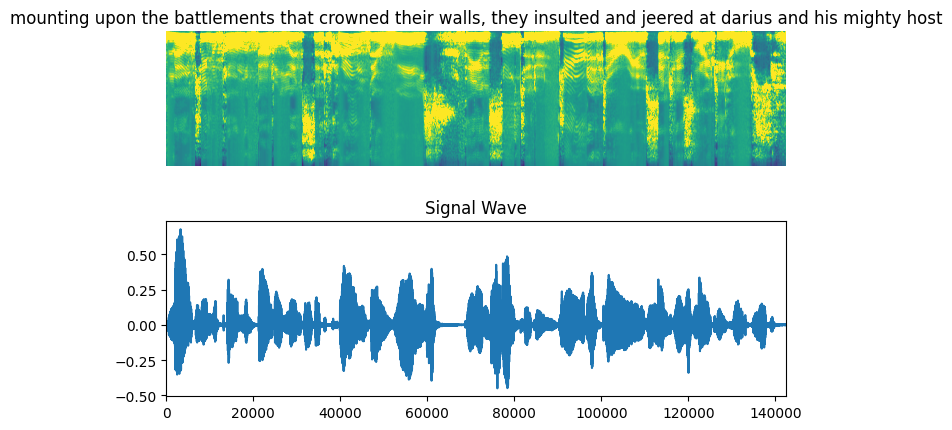

In [20]:
fig = plt.figure(figsize=(8, 5))

for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]

    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode('utf-8')
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")


    file = tf.io.read_file(wave_Path + list(train_df["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()

    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))

plt.show()

In [21]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

    return loss



# def CTCLoss (y_true, y_pred):
#   # Compute the aining-time loss value
#   batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
#   input_length = tf.cast (tf.shape (y_pred) [1], dtype="int64")
#   label_length= tf.cast(tf.shape(y_true) [1], dtype="int64")

#   input_length= input_length* tf.ones(shape=(batch_len, 1), dtype="int64")
#   label_length= label_length *tf.ones(shape=(batch_len, 1), dtype="int64")

#   loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

#   return loss

In [22]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input_spectrogram")

    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)

    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1"
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)

    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2"
    )(x)

    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)

    # Reshape the resulted volume to feed the RNN layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

    # RNN Layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}"
            )
        x = layers.Bidirectional(
                recurrent,name = f"bidirectional_{i}", merge_mode = "concat"
        )(x)

        # Add dropout if it's not the last layer
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)

    # Dense layer 1
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)

    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)

    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")

    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)

    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)  # Assuming you are using sparse categorical crossentropy

    return model

In [23]:
# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1 ,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input_spectrogram (InputLayer)                  [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

In [24]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text=[]
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

In [25]:
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        predictions = []
        targets = []

        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)

            for label in y:
                label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                targets.append(label)

        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)

        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target: {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)


In [1]:
epochs = 30

validation_callback = CallbackEval(test_dataset)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

NameError: ignored